In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
np.random.seed(0)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
class adversial_env(object):
    def __init__(self,runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        self.mask = np.random.choice([1],size = [1,10])
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(2*self.env.observation_space.shape[0],))
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        self.obsr = np.concatenate((self.obsr, self.obsr), axis=0)
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        if self.epi_num%300 == 299:
            self.mask = np.random.choice([1],size = [1,10])
            self.mask[0,np.random.randint(0,9, size=1)[0]] = 0 
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*self.mask)[0]
            
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        self.obsr = np.concatenate((self.obsr, self.obsr), axis=0)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.mask = np.random.choice([1],size = [1,10])
        self.obsr = self.env.reset()
        self.obsr = np.concatenate((self.obsr, self.obsr), axis=0)
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

Every 300 step change a sensor to mask

# define an observer (new agent) and save running state

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)


[2018-04-05 20:07:22,916] Making new env: RoboschoolInvertedPendulum-v1


In [4]:
agn.learn()

23.0 [23.0] [24]
Episode 0	Last reward: 23.0	Average reward 22.41
('lagrange multiplier:', 1.0149201154164378, 'grad_norm:', 0.17560540892361895)
fval before 5.997064200052357e-15
a/e/r 0.02024162174372627 0.020298402308328748 0.997202707693936
fval after -0.02024162174372027
Episode 1	Last reward: 88.0	Average reward 28.36
('lagrange multiplier:', 1.4771617255294331, 'grad_norm:', 0.2480241386911532)
fval before 2.9160498001056152e-15
a/e/r 0.03233246175232919 0.029543234510591383 1.0944117083976657
fval after -0.03233246175232628
Episode 2	Last reward: 59.0	Average reward 40.79
('lagrange multiplier:', 1.489285635707078, 'grad_norm:', 0.2641198320489245)
fval before -1.6838635248878278e-15
a/e/r 0.031976867220135353 0.02978571271414512 1.0735639441304912
fval after -0.03197686722013704
Episode 3	Last reward: 84.0	Average reward 68.20
('lagrange multiplier:', 1.4221482980188263, 'grad_norm:', 0.26694044832167674)
fval before -3.7398544499723845e-15
a/e/r 0.029185403092136335 0.0284429

[2018-04-05 20:19:14,387] Making new env: RoboschoolInvertedPendulum-v1


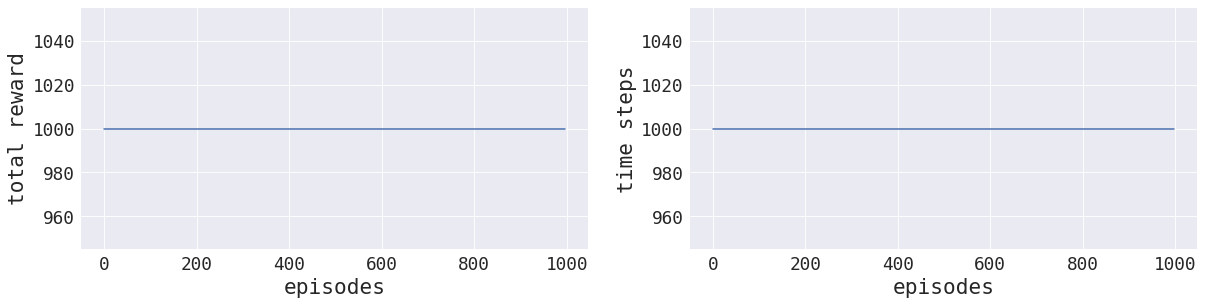

In [5]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

env.result_plot()

In [6]:
agn.save_model('agent_model/random_period_mask_observer_double_sensor')

# Without adversarial training 

In [7]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-04-05 20:28:29,940] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


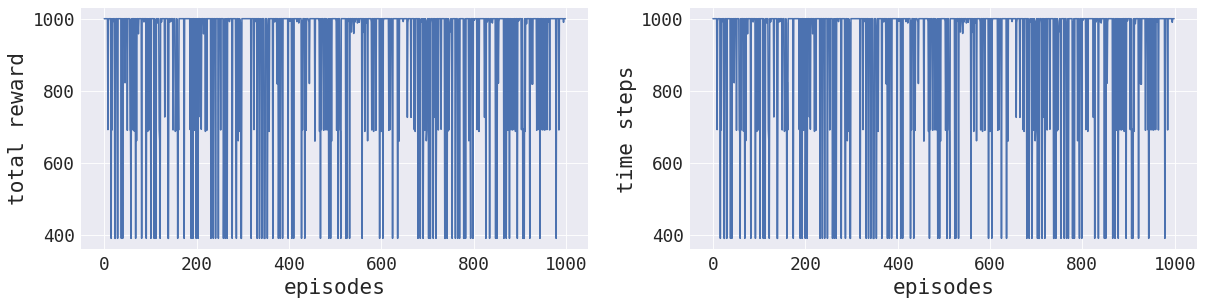

In [8]:
env.result_plot()

In [9]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_period_mask_observer_double_sensor')

[2018-04-05 20:37:07,159] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [10]:
agn.learn(run_state_update = False) # disable running state update

996.0 [996.0] [997]
Episode 0	Last reward: 1000.0	Average reward 794.03
('lagrange multiplier:', 0.37404495540775806, 'grad_norm:', 0.056558132951951015)
fval before -1.4402817713220384e-16
a/e/r 0.006965872015202048 0.0074808990692156185 0.931154390769294
fval after -0.006965872015202192
Episode 1	Last reward: 969.0	Average reward 838.27
('lagrange multiplier:', 0.27761622789836377, 'grad_norm:', 0.035947186762578714)
fval before -5.30967984277337e-16
a/e/r 0.005500707354210123 0.005552324585078685 0.9907034918298403
fval after -0.0055007073542106535
Episode 2	Last reward: 435.0	Average reward 893.24
('lagrange multiplier:', 0.27695853649173163, 'grad_norm:', 0.043448427770634325)
fval before -2.4032346146162722e-17
a/e/r 0.0055195652302885995 0.005539170745374878 0.9964605685602581
fval after -0.005519565230288624
Episode 3	Last reward: 1000.0	Average reward 901.76
('lagrange multiplier:', 0.3156525429764205, 'grad_norm:', 0.054426816890757394)
fval before 3.172780661119122e-16
a/e/r

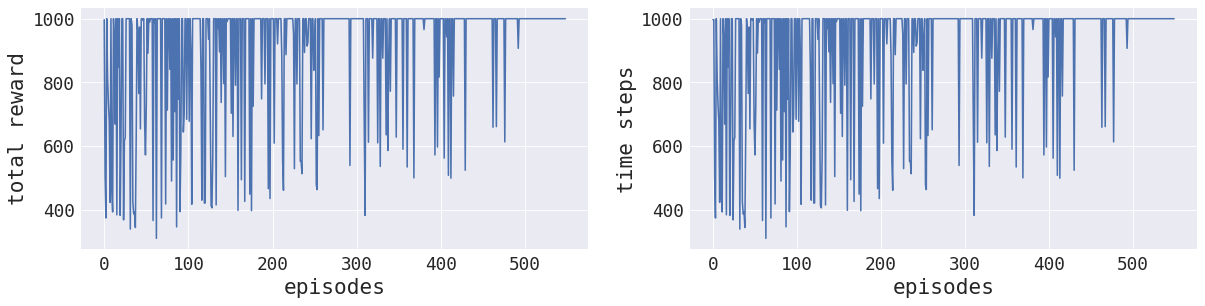

In [11]:
env.result_plot()

# Agent evaluation

In [12]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-04-05 20:45:42,685] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


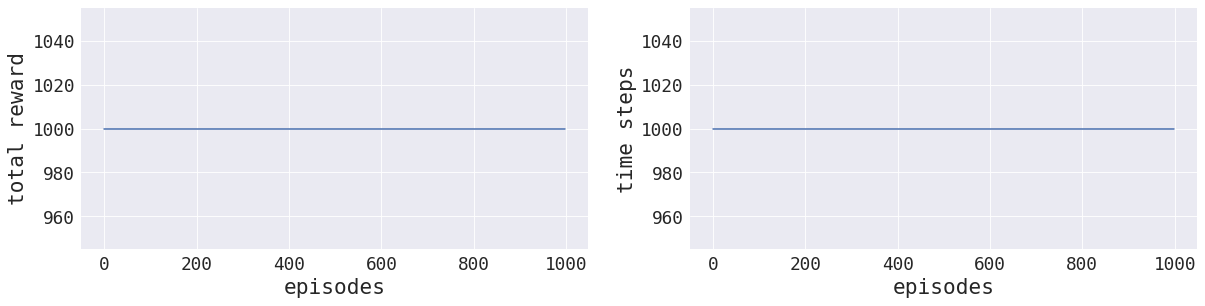

In [13]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [14]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-04-05 20:54:34,510] Making new env: RoboschoolInvertedPendulum-v1


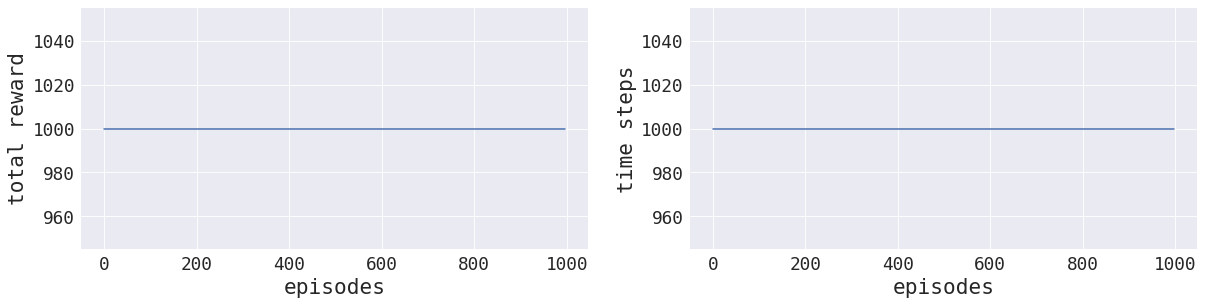

In [15]:
env.result_plot()

# Save model

In [16]:
agn.save_model('agent_model/random_period_mask_observer_double_sensor')